In [112]:
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import scipy.stats.distributions as dist

import urllib
from PIL import Image

source_dir = '../../fits/'
data_file = 'volume_limited_sample.fits'
debiased_file = 'debiased_volume_limited_sample.fits'

#-------------------------------------------------------
import matplotlib as mpl
from prefig import Prefig
Prefig()
% matplotlib inline

from matplotlib.ticker import MaxNLocator

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 6
mpl.ticker.AutoLocator.default_params['prune'] = 'both'
#------------------------------------------------------

% matplotlib inline

In [73]:
def assign(table,debiased_table,th=0,redistribute=False,rd_th=0,ct_th=0,print_sizes=False,raw=False):
    
    m_columns = debiased_table.colnames
    
    if raw == True:
        m_array = np.array([table[column] for column in m_columns]).T
    else:
        m_array = np.array([debiased_table[column] for column in m_columns]).T
    
    arm_assignments = np.ones(len(table))*(-999) # Assigned arm numbers 
    # initially is an array of -999s. -999 means 'no assignment'.
    for m in range(6):
        a = (np.argmax(m_array,axis=1) == m) & (m_array[:,m] >= th)
        arm_assignments[a] = m
        
    if redistribute is True: # Redistribute according to thresholds.
        for m in range(5):
            arm_assignments[(np.argmax(m_array[:,:5],axis=1) == m) 
                & (arm_assignments == 5) & (table[:,m]/table[:,5] > rd_th) 
                & (table[:,5] <= ct_th)] = m

    if print_sizes is True:
        print("total sample: " + str(len(arm_assignments)))
        print("total 'assigned' sample: " 
              + str(np.sum(arm_assignments != -999)))
        for m in range(6):
            print("m = " + str(m+1) + ": " 
                  + str(np.sum(arm_assignments == m)))
      
    return arm_assignments

In [2]:
data = fits.getdata(source_dir + data_file,1)
data_table = Table(data)
debiased = fits.getdata(source_dir + debiased_file,1)
debiased_table = Table(debiased)

In [37]:
p_th = 0.5
N_th = 5

p_spiral = (data.field("t01_smooth_or_features_a02_features_or_disk_debiased")
            *data.field("t02_edgeon_a05_no_debiased")
            *data.field("t04_spiral_a08_spiral_debiased"))
N_spiral = (data.field("t04_spiral_a08_spiral_count")) # Load values to
# allow data cuts to be made.
    
select_spiral = (p_spiral > p_th) & (N_spiral >= N_th)
spirals = data_table[select_spiral]
deb_spirals = debiased_table[select_spiral]

s82_select = np.logical_or(spirals['sample'] == 'stripe82_coadd_1',spirals['sample'] == 'stripe82')

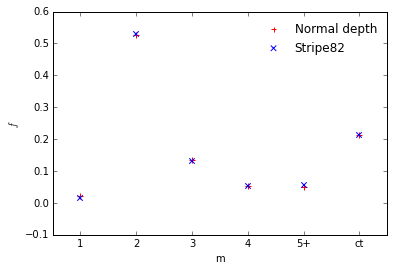

In [63]:
# Look at the fractions of 1,2,3,4,5+ ... 

ax = plt.subplot(1,1,1)

for s82 in [False,True]:
    
    if s82 == True:
        c = 'b'
        l = 'Stripe82'
        mark = 'x'
    else:
        c = 'r'
        l = 'Normal depth'
        mark = '+'

    data_s = spirals[s82_select == s82]
    deb_s = deb_spirals[s82_select == s82]
    m_vals = assign(data_s,deb_s)
    
    ms = range(6)
    
    fractions = np.array([np.sum(m_vals == m)/len(m_vals) for m in ms])
    plt.scatter(ms,fractions,color=c,label=l,marker=mark,s=30)
        
    plt.legend(scatterpoints=1,frameon=False)
    plt.xlim(-0.5,5.5)
    labels = ['0','1','2','3','4','5+','ct']
    ax.set_xticklabels(labels)
    plt.xlabel('m')
    plt.ylabel('$f_{debiased}$')

# Looks fine (maybe suggesting that the debiasing procedure is matching everything OK).

In [70]:
def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

In [71]:
def binned_morph_frac(morph, bins):
    total = np.bincount(bins)[1:]
    frac = []
    for m in np.unique(morph):
        count = np.bincount(bins[morph == m], minlength=bins.max()+1)[1:]
        frac.append(frac_errors(count, total))
    return frac

In [100]:
def plot_morph_frac_trend(x, frac,frac_raw=None, xlabel='redshift', answerlabels=None,label_position=[0.04,0.95]):
    C = ['orange','red','magenta','green','blue','purple']
    nmorph = len(frac)
    fig, axarr = plt.subplots(6, 1, sharex=True, sharey=False, figsize=(10, 3*nmorph))
    
    for m in range(6):
        ax = axarr[m]
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune="upper"))
        if frac_raw is not None:
            ax.plot(x, frac_raw[m]['frac'], '--', color=C[m], lw=2, alpha=0.5)
            ax.fill_between(x, frac_raw[m]['low'], frac_raw[m]['high'], color=C[m], alpha=0.25)
        mean = frac[m]['frac'].mean()
        ax.hlines([mean], -100, 100, linestyle=':', color=C[m], lw=3)
        ax.plot(x, frac[m]['frac'], color=C[m], lw=2)
        ax.fill_between(x, frac[m]['low'], frac[m]['high'], color=C[m], alpha=0.5)
        
        ax.set_ylabel('fraction',fontsize=18)
        if answerlabels is not None:
            ax.text(label_position[0], label_position[1], answerlabels[m], transform=ax.transAxes, va='top',fontsize=20)
            
            ax.yaxis.set_major_locator(MaxNLocator(nbins=6,prune='both'))
    ax.set_xlabel(xlabel,fontsize=18)
    
    plt.subplots_adjust(hspace=0)

In [80]:
def frac_errors(k, n, c=0.683):
    # Gets the errors according to the Cameron et al. paper.
    
    # cope with both array and individual value inputs
    k = np.array(k, np.float, ndmin=1)
    frac = k / n
    low = dist.beta.ppf((1-c)/2., k+1, n-k+1)
    high = dist.beta.ppf(1-(1-c)/2., k+1, n-k+1)    
    # ensure confidence intervals are sensible for
    # extreme fractions
    low = np.where(frac < low, 0.0, low)
    high = np.where(frac > high, 1.0, high)
    # return sensible shaped arrays
    out = Table((frac, low, high), names=('frac', 'low', 'high'))
    return out

(0.04, 0.085)

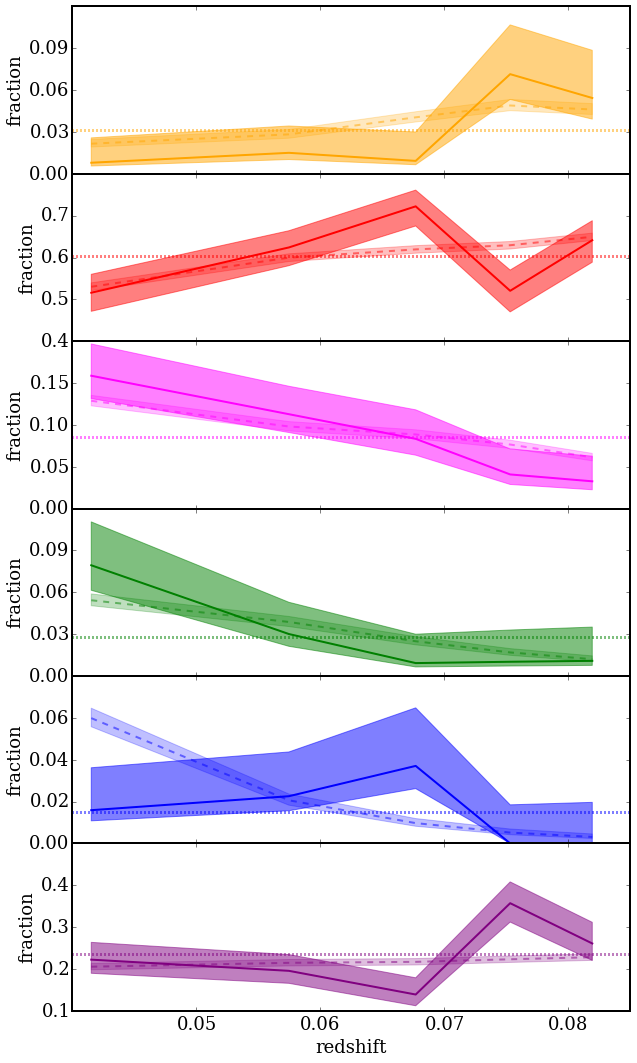

In [101]:
# How do the raw vote fractions change w. redshift?

bin_centres,bin_values = bin_by_column(spirals['REDSHIFT_1'],5)
assignments = assign(spirals,deb_spirals,raw=True)

for s82 in [False,True]:
    
    data_s = spirals[s82_select == s82]
    m_vals = assignments[s82_select == s82]
    bin_s = bin_values[s82_select == s82]
    
    if s82 == False:
        frac_norm = binned_morph_frac(m_vals,bin_s)
    else:
        frac_s82 = binned_morph_frac(m_vals,bin_s)
        
plot_morph_frac_trend(bin_centres,frac_s82,frac_raw=frac_norm)
plt.xlim(0.04,0.085)

# -> Can't really see any differences beween the S82 and the normal data.

In [115]:
def display_image(url_name,crop_in=100):
    # Get the url name:
    urllib.request.urlretrieve(url_name,"image.jpg")
    # Open -> crop -> display -> remove the image.
    im=Image.open("image.jpg")
    l=424 # Image size
    im=im.crop((crop_in,crop_in,l-crop_in,l-crop_in))
    plt.imshow(im)
    os.remove("image.jpg")
    plt.xticks([])
    plt.yticks([])
    return None

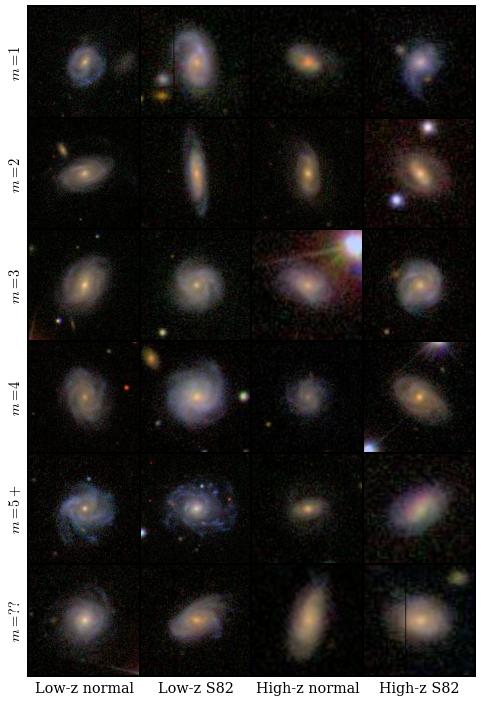

In [126]:
# Some random images from S82 compared with normal depth:
random.seed(0)

bin_centres,bin_values = bin_by_column(spirals['REDSHIFT_1'],5)
assignments = assign(spirals,deb_spirals,raw=False)

fig,axes = plt.subplots(6,4,figsize=(8,12))
plt.subplots_adjust(hspace=0,wspace=0)
ylabels = [r'$m={{{}}}$'.format(m) for m in ['1','2','3','4','5+',"??"]]
xlabels = ['Low-z normal','Low-z S82','High-z normal','High-z S82']
for m in range(6):
    axes[m,0].set_ylabel(ylabels[m])
for n in range(4):
    axes[-1,n].set_xlabel(xlabels[n])

for s82 in [False,True]:
    
    if s82 == False:
        col_start = 0
    else:
        col_start = 1
    
    data_s = spirals[s82_select == s82]
    m_vals = assignments[s82_select == s82]
    bin_s = bin_values[s82_select == s82]
    
    for m in range(6):
        
        data_m = data_s[m_vals == m]
        bin_m = bin_s[m_vals == m]
        # Select highest + lowest z bin:
        hi_z = data_m[bin_m == np.max(np.unique(bin_m))]
        lo_z = data_m[bin_m == np.min(np.unique(bin_m))]
        
        plt.sca(axes[m,col_start])
        url = random.choice(lo_z['jpeg_url'])
        display_image(url)
        
        plt.sca(axes[m,col_start+2])
        url = random.choice(hi_z['jpeg_url'])
        display_image(url)
        
# Would have to match by fraction + mass to investigate this further.